<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Computing with Multiple Objects

Learning goals:

- Perform operations across multiple datasets
- Understand two important concepts: broadcasting and alignment.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%config InlineBackend.figure_format='retina'

plt.style.use("bmh")

np.random.seed(0)

Here is a motivating calculation where we subtract two DataArrays with data available at different locations in the (space, time) plane.

In [2]:
arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
arr1

<xarray.DataArray (space: 3, time: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

In [3]:
arr2 = xr.DataArray(
    [0, 1],
    dims="space",
    coords={"space": ["b", "d"]},
)
arr2

<xarray.DataArray (space: 2)>
array([0, 1])
Coordinates:
  * space    (space) <U1 'b' 'd'

Note that `arr1` is 2D; while `arr2` is 1D along `space` and has values at two locations only.

Now subtract the two.

In [4]:
arr1 - arr2

<xarray.DataArray (space: 1, time: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

To understand this output, we must understand two fundamental concepts underlying computation with Xarray objects

1. Broadcasting: The objects need to have compatible shapes.
2. Alignment: The objects need to have values at the same coordinate labels



## Broadcasting: adjusting arrays to the same shape

**Broadcasting** allows an operator or a function to act on two or more arrays
to operate even if these arrays do not have the same shape. That said, not all
the dimensions can be subjected to broadcasting; they must meet certain rules.
The image below illustrates how an operation on arrays with
different coordinates will result in automatic broadcasting

![](../images/broadcasting_schematic.png)

Credit: Stephan Hoyer --
[xarray ECMWF Python workshop](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_154)

Numpy's broadcasting rules, based on array shape, can sometimes be
difficult to understand and remember. Xarray does broadcasting by dimension name,
rather than array shape. This is a huge convenience.

Here are two 1D arrays

In [5]:
array1 = xr.DataArray(
    np.arange(3),
    dims="space",
    coords={"space": ["a", "b", "c"]},
    name="array1",
)
array2 = xr.DataArray(
    np.arange(4),
    dims="time",
    coords={"time": [0, 1, 2, 3]},
    name="array2",
)
display(array1)
display(array2)

<xarray.DataArray 'array1' (space: 3)>
array([0, 1, 2])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'

<xarray.DataArray 'array2' (time: 4)>
array([0, 1, 2, 3])
Coordinates:
  * time     (time) int64 0 1 2 3

Let's subtract the two:

In [6]:
array1 - array2

<xarray.DataArray (space: 3, time: 4)>
array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

We see that the result is a 2D array. 

When subtracting, Xarray first realizes that `array1` is missing the dimension `time` and `array2` is missing the dimension `space`.  Xarray then broadcasts or "expands" both arrays to 2D with dimensions `space`, `time`. Here is an illustration:

![](../images/broadcasting_schematic.png)

While this detail is hidden, we can explicitly broadcast any number of arrays against each other using [xr.broadcast](https://xarray.pydata.org/en/stable/generated/xarray.broadcast.html)

In [7]:
array1_broadcasted, array2_broadcasted = xr.broadcast(array1, array2)
display(array1_broadcasted.dims)
display(array2_broadcasted.dims)

('space', 'time')

('space', 'time')

To get the final anomaly, Xarray calculates

In [8]:
# identical to array1 - array2
array1_broadcasted - array2_broadcasted

<xarray.DataArray (space: 3, time: 4)>
array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

### Broadcasting in numpy

For contrast let us examine the pure numpy version  of this calculation. We use [.data](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.data.html) to extract the underlying numpy array object.


In [9]:
array1.data - array2.data

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

To get this calculation to work, we need to insert new axes manually using [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis).

In [10]:
array1.data[:, np.newaxis] - array2.data[np.newaxis, :]

array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])


Because xarray knows about dimension names we avoid having to create unnecessary
size-1 dimensions using `np.newaxis` or `.reshape`. This is yet another example where the _metadata_ (dimension names) reduces the mental overhead associated with coding a calculation

For more, see the [Xarray documentation](https://xarray.pydata.org/en/stable/computation.html#broadcasting-by-dimension-name) and the [numpy documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html) on broadcasting.


### Exercise

Consider the following 2D array. What are the dimensions of `array - array.mean("time")`?

In [13]:
array = array1 - array2
array

<xarray.DataArray (space: 3, time: 4)>
array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

In [14]:
array.mean("time")

<xarray.DataArray (space: 3)>
array([-1.5, -0.5,  0.5])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'

In [17]:
array = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
    name="array",
)

In [16]:
(array - array.mean("time")).dims

('space', 'time')

In [18]:
array

<xarray.DataArray 'array' (space: 3, time: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

In [19]:
array - array.mean("time")

<xarray.DataArray 'array' (space: 3, time: 4)>
array([[-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

## Alignment: putting data on the same grid


When combining two input arrays using an arithmetic operation, both arrays must first be converted to the same coordinate system. This is "alignment".

![](../images/alignment_schematic.png)


Here are two 2D DataArrays with different shapes.

In [20]:
arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
arr1

<xarray.DataArray (space: 3, time: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * space    (space) <U1 'a' 'b' 'c'
  * time     (time) int64 0 1 2 3

In [21]:
arr2 = xr.DataArray(
    np.arange(14).reshape(2, 7),
    dims=("space", "time"),
    coords={"space": ["b", "d"], "time": [-2, -1, 0, 1, 2, 3, 4]},
)
arr2

<xarray.DataArray (space: 2, time: 7)>
array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13]])
Coordinates:
  * space    (space) <U1 'b' 'd'
  * time     (time) int64 -2 -1 0 1 2 3 4

`arr1` and `arr2` have the same dimensions (space, time) but have values at different locations in the (space, time) plane  with some locations in common.

:::{note}
xarray assumes coordinate labels are in the same coordinate system such that space='b' in arr1 is the same as space='b' in arr2. For more sophisticated handling of coordinate systems see [rioxarray](https://corteva.github.io/rioxarray/stable/)
:::

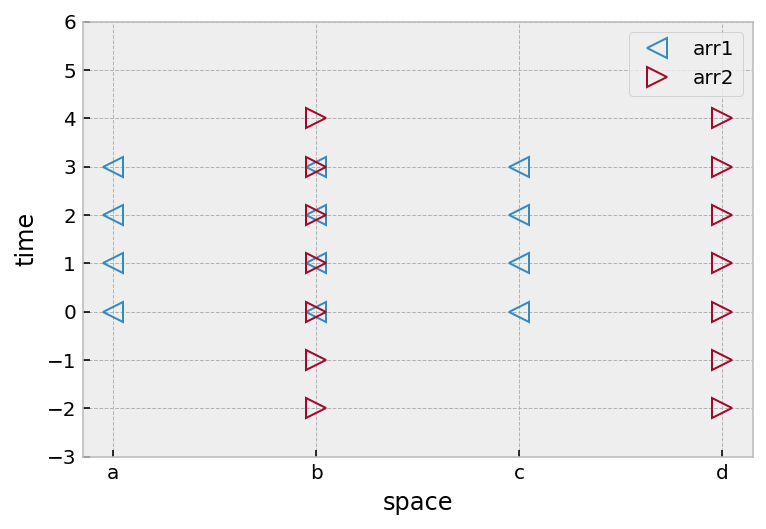

In [22]:
def visualize_mesh(array, *args, ax=None, **kwargs):
    """Visualizes array's mesh ((points at which values are present)."""

    # Use broadcast to generate 2D x_, y_ arrays from the 1D x,y arrays
    space_, time_ = xr.broadcast(array.space, array.time)
    if ax is None:
        ax = plt.gca()
    kwargs.setdefault("fillstyle", "none")
    kwargs.setdefault("markersize", 10)
    ax.plot(space_.data.ravel(), time_.data.ravel(), *args, **kwargs)
    ax.set_xlabel("space")
    ax.set_ylabel("time")


visualize_mesh(arr1, "<")
visualize_mesh(arr2, ">")
plt.ylim([-3, 6])
plt.legend(["arr1", "arr2"]);

We see that both arrays only have values in common at `x="b"` and `y=[0, 1, 2, 3]`. Before applying an arithmetic operation we must first modify each DataArray so that they have values at the *same* points. This is "alignment".

### Controlling alignment

We can explicitly align objects using [xr.align](https://xarray.pydata.org/en/stable/generated/xarray.align.html). The key decision to make is how to decide which points must be kept. The other way to think of alignment is that objects must be converted to a common grid prior to any operation combining multiiple objects. This decision is controlled by the `"join"` keyword argument. Xarray provides 5 ways to convert the coordinate labels of multiple Datasets to a common grid. This [terminology](https://en.wikipedia.org/wiki/Join_(SQL)) originates in the database community.

1. `join="inner"` or reindex to the "intersection set" of coordinate labels
2. `join="outer"` or reindex to the "union set" of coordinate labels
3. `join="left"`  or reindex to the coordinate labels of the leftmost object
4. `join="right"` or reindex to the coordinate labels of the rightmost object
5. `join="exact"` checks for exact equality of coordinate labels before the operation.

First lets try an inner join. This is the default for arithmetic operations in Xarray. We see that the result has values for locations that `arr1` and `arr2` have in common: `x="b"` and `y=[0, 1, 2, 3]`. Here is an illustration

![](../images/alignment_schematic.png)

In [23]:
a1_aligned, a2_aligned = xr.align(arr1, arr2, join="inner")
a1_aligned

<xarray.DataArray (space: 1, time: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

In [24]:
a2_aligned

<xarray.DataArray (space: 1, time: 4)>
array([[2, 3, 4, 5]])
Coordinates:
  * space    (space) <U1 'b'
  * time     (time) int64 0 1 2 3

Here's a visual depiction of all the `join` options

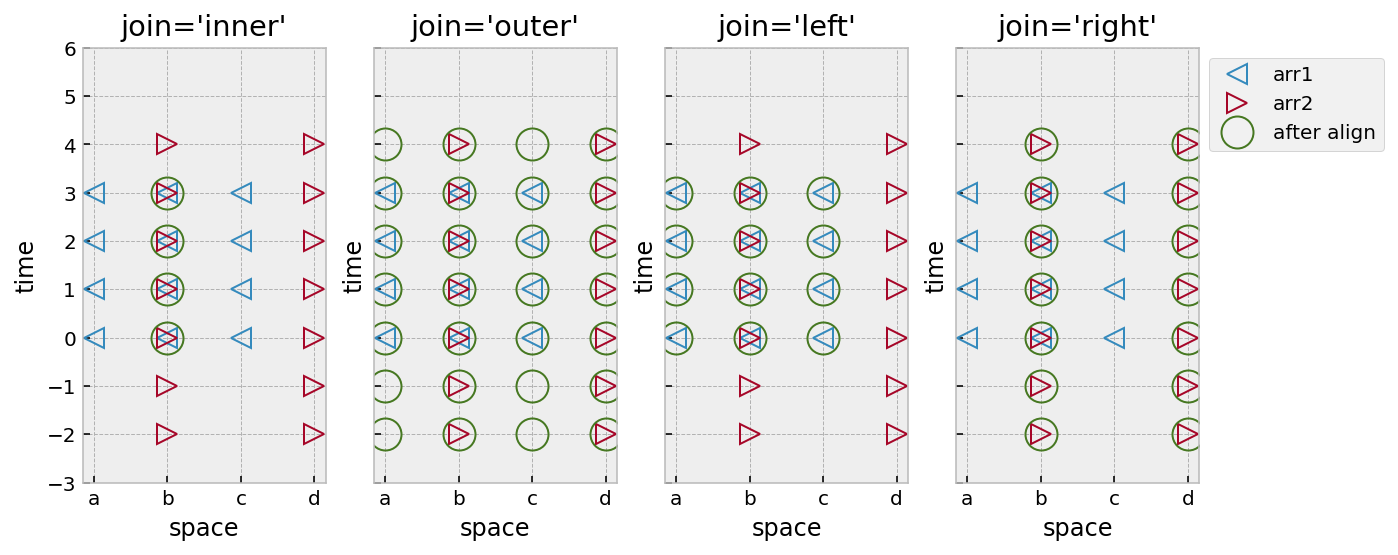

In [25]:
def visualize_join(a1, a2, join, ax=None):
    a1_aligned, a2_aligned = xr.align(arr1, arr2, join=join)

    visualize_mesh(a1, "<", ax=ax)
    visualize_mesh(a2, ">", ax=ax)
    visualize_mesh(a1_aligned, ".", markersize=32, color="C3", ax=ax)

    ax.set_ylim([-3, 6])
    ax.set_title(f"join={join!r}")


f, ax = plt.subplots(1, 4, sharex=True, sharey=True)
for axx, join in zip(ax, ["inner", "outer", "left", "right"]):
    visualize_join(arr1, arr2, join, ax=axx)
ax[-1].legend(["arr1", "arr2", "after align"], bbox_to_anchor=(1, 1))
f.set_size_inches(10, 4);

**Exercise**  Consider the following two arrays. Write down the `x` and `y` coordinate locations for `da1 - da2`

In [26]:
da1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("space", "time"),
    coords={"space": ["a", "b", "c"], "time": [0, 1, 2, 3]},
)
da2 = xr.DataArray(
    [0, 1],
    dims="space",
    coords={"space": ["b", "d"]},
)

**Answer** `x = ["b"], y=[0, 1, 2, 3]` . `da2` has been broadcasted to 2D  (so dimension "y" has been inserted) and the two arrays are aligned using `join="inner"` prior to subtraction.

### Further control over alignment

#### Controlling the fill value

For all join options other than `"inner"` Xarray will insert a `fill_value` at locations not present in the original dataset. By default this is NaN

In [ ]:
arr1_aligned, _ = xr.align(arr1, arr2, join="outer")
arr1_aligned

Control the "fill value" by specifying the `fill_value` keyword argument

In [ ]:
arr1_aligned, _ = xr.align(arr1, arr2, join="outer", fill_value=0)
arr1_aligned

#### Checking that objects are aligned

`join="exact"` is special in that it checks to make sure that the objects _are_ aligned.

For `arr1` and `arr2` this will raise an error since `arr1.x` is not identical to `arr2.x` (and similarly for `y`)

In [ ]:
xr.align(arr1, arr2, join="exact")

#### Controlling automatic alignment

Xarray's default for arithmetic operations is `join="inner"`. This is controllable using the [xr.set_options](https://docs.xarray.dev/en/stable/generated/xarray.set_options.html) context manager

In [ ]:
with xr.set_options(arithmetic_join="outer"):
    result = arr1 - arr2
result